<a href="https://colab.research.google.com/github/glitch-y/CE888-Project/blob/main/2.%20Scripts/2.%20Preprocessing_Hate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contractions
!pip install emot

     |████████████████████████████████| 266kB 5.2MB/s 
     |████████████████████████████████| 327kB 7.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85265 sha256=202f826b42716f343bda66cda6141ebff355d1ca557049f6e27ff5f1ffb4346c
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


# Import Modules
Import modules for preprocessing

In [2]:
#Import modules
import html #import 'html' module to clean html elements such as '&amp;, &lt' etc.
import numpy as np
import pandas as pd
import contractions #import 'contractions' module to expand linguistic contactions (e.g. it's = it is)
from emot import UNICODE_EMO #import emoji dictionary to transform emojis into text
import re
import seaborn as sns

# Import Data
Import data from TweetEval Github

In [3]:
#Import files for the 'hate' task
data_hate_test = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt", 
                                delimiter='\t', dtype=str, header= None)
data_hate_test_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_hate_mapping = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_hate_train = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_hate_train_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_hate_val = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_hate_val_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)

#Assign column names for hate datasets
data_hate_test.columns =['content']
data_hate_test_labels.columns =['labels']
data_hate_mapping.columns =['labels','mapping']
data_hate_train.columns =['content']
data_hate_train_labels.columns =['labels']
data_hate_val.columns =['content']
data_hate_val_labels.columns =['labels'] 

# Preprocessing

##Replace misspelled words

Typos are common in text data and the scripts below create a dictionary of commonly mispelled words and applies it against the 3 'text' sets

In [4]:
#Import misspelling data as dictionary
misspell_data = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/Misspelling.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Preview misspelling dictionary
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(10)]}

{'Steffen': 'Stephen',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'bout': 'about',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

In [5]:
#Create misspelling correction function
def misspelled_correction(x):
    for i in x.split(): 
        if i in miss_corr.keys(): 
            x = x.replace(i, miss_corr[i]) 
    return x

#Apply misspelling correction to text dataframes as new column
data_hate_test['content_clean'] = data_hate_test.content.apply(lambda x : misspelled_correction(x).lower())
data_hate_train['content_clean'] = data_hate_train.content.apply(lambda x : misspelled_correction(x).lower())
data_hate_val['content_clean'] = data_hate_val.content.apply(lambda x : misspelled_correction(x).lower())

##Replace abbreviated words

Social media users normally use abbreviated text due to the fast nature of writing a post as well as certain limitations in terms of characters (a well-known aspect of Twitter. 

The script below create a dictionary of commonly known internet abbreviations and applies it against the 3 'text' data sets.

In [6]:
#Abbreviated chat words conversion
#Create Dictionary
chat_dictionary = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/SlangDictionary.csv",dtype=str, names=["Slang", "Translation"])
chat_dictionary=chat_dictionary.apply(lambda x: x.str.lower())
slang_corr = dict(zip(chat_dictionary.Slang, chat_dictionary.Translation))

#Preview abbreviation dictionary
{v:slang_corr[v] for v in [list(slang_corr.keys())[k] for k in range(10)]}

{'a.s.a.p.': 'as soon as possible',
 'af': 'as fuck',
 'ama': 'ask me anything',
 'asap': 'as soon as possible',
 'atk': 'at the keyboard',
 'atm': 'at the moment',
 'bbl': 'be back later',
 'bcs': 'because',
 'bcus': 'because',
 'bcuz': 'because'}

In [7]:
#Create abbreviation replacement function
def abbrev_replace(x):
    for i in x.split(): 
        if i in slang_corr.keys(): 
            x = x.replace(i, slang_corr[i]) 
    return x

#Apply misspelling correction to dataframe as new column
data_hate_test.content_clean = data_hate_test.content_clean.apply(lambda x : abbrev_replace(x))
data_hate_train.content_clean = data_hate_train.content_clean.apply(lambda x : abbrev_replace(x))
data_hate_val.content_clean = data_hate_val.content_clean.apply(lambda x : abbrev_replace(x))

#Check
data_hate_train.head()

,content,content_clean
0,@user nice new signage. Are you not concerned ...,@user nice new signage. are you not concerned ...
1,A woman who you fucked multiple times saying y...,a woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user,hysterical woman like @user


##Remove HTML elements

Data scraped from various websites usually returns certain html elements such as '&amp;' for '&'

The script below uses the 'html' module to clean the data of any such occurences

In [8]:
#clean HTML charachters such as &amp;, &lt; etc using 'html' module
data_hate_test.content_clean = data_hate_test.content_clean.apply(lambda x: html.unescape(x))
data_hate_train.content_clean = data_hate_train.content_clean.apply(lambda x: html.unescape(x))
data_hate_val.content_clean = data_hate_val.content_clean.apply(lambda x: html.unescape(x))

##Fix language contractions

The script below uses the 'contractions' module to expand any language contractions such as 'let's' into 'let us' or 'it's' into 'it is'

In [9]:
#fix contractions; i.e. 'It's' transforms into 'it is'
data_hate_test.content_clean = data_hate_test.content_clean.apply(lambda x: contractions.fix(x))
data_hate_train.content_clean = data_hate_train.content_clean.apply(lambda x: contractions.fix(x))
data_hate_val.content_clean = data_hate_val.content_clean.apply(lambda x: contractions.fix(x))

##Remove 'newlines' and replace '&' with 'and'


In [10]:
#Remove newlines from data and replace '&' with 'and'
data_hate_test.content_clean = data_hate_test.content_clean.replace(r'\\n',' ', regex=True)
data_hate_test.content_clean = data_hate_test.content_clean.replace(r'&','and', regex=True)

data_hate_train.content_clean = data_hate_train.content_clean.replace(r'\\n',' ', regex=True)
data_hate_train.content_clean = data_hate_train.content_clean.replace(r'&','and', regex=True)

data_hate_val.content_clean = data_hate_val.content_clean.replace(r'\\n',' ', regex=True)
data_hate_val.content_clean = data_hate_val.content_clean.replace(r'&','and', regex=True)

##Convert emojis into text

Emoji's describe a variety of hates or objects which can help increase the accuracy of the algorithm. 

The script below uses the 'emot' module to lookup emoji's in the module dictionary and translate them into text.


In [11]:
#convert emojis into text
def convert_emojis(x):
    for emot in UNICODE_EMO:
        x = x.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return x

data_hate_test.content_clean = data_hate_test.content_clean.apply(lambda x: convert_emojis(x))
data_hate_train.content_clean = data_hate_train.content_clean.apply(lambda x: convert_emojis(x))
data_hate_val.content_clean = data_hate_val.content_clean.apply(lambda x: convert_emojis(x))

##Remove unnecessary punctuation

Certain types of punctuation is not of particular use and is removed using the script below. 

However, commas, periods, exclamation marks, question marks apostrophes have not been taken out as they help set the tone or define the relationships between words.


In [12]:
#Remove unnecessary punctuation
def punctuation(x): 
  
    punctuations = '()-[]{};:\<>/#$%^&_~'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " ") 
    return x

data_hate_test.content_clean = data_hate_test.content_clean.apply(lambda x: punctuation(x))
data_hate_train.content_clean = data_hate_train.content_clean.apply(lambda x: punctuation(x))
data_hate_val.content_clean = data_hate_val.content_clean.apply(lambda x: punctuation(x))

##Remove '@user' mentions


In [13]:
#Remove @user mentions
data_hate_test.content_clean = data_hate_test.content_clean.str.replace('@user','')
data_hate_train.content_clean = data_hate_train.content_clean.str.replace('@user','')
data_hate_val.content_clean = data_hate_val.content_clean.str.replace('@user','')


data_hate_test.head()

,content,content_clean
0,"@user , you are correct that Reid certainly is...",", you are correct that reid certainly is a we..."
1,Whoever just unfollowed me you a bitch,whoever just unfollowed me you a bitch
2,@user @user Those People Invaded Us!!! They DO...,those people invaded us!!! they do not belin...
3,"stop JUDGING bitches by there cover, jus cuz s...","stop judging bitches by there cover, just beca..."
4,how about i knock heads off and send them gift...,how about i knock heads off and send them gift...


##Assign labels to Tweet datasets

The script below assigns the labels to the 3 separate 'text' files.

In [14]:
#Test Data
data_hate_test.reset_index(inplace=True)
data_hate_test_labels.reset_index(inplace=True)
processed_hate_test=data_hate_test.merge(data_hate_test_labels)

#Train Data
data_hate_train.reset_index(inplace=True)
data_hate_train_labels.reset_index(inplace=True)
processed_hate_train=data_hate_train.merge(data_hate_train_labels)

#Val Data
data_hate_val.reset_index(inplace=True)
data_hate_val_labels.reset_index(inplace=True)
processed_hate_val=data_hate_val.merge(data_hate_val_labels)

##Map labels
Map each row with the respective hate tags, based on the values in column 'Labels'


In [15]:
#hate test data mapping
mapped_hate_test=processed_hate_test[['labels','content_clean']].merge(data_hate_mapping,how='left')

#Check
print(mapped_hate_test)

     labels                                      content_clean   mapping
0         0   , you are correct that reid certainly is a we...  not-hate
1         1            whoever just unfollowed me you a bitch       hate
2         1    those people invaded us!!! they do not belin...      hate
3         1  stop judging bitches by there cover, just beca...      hate
4         1  how about i knock heads off and send them gift...      hate
...     ...                                                ...       ...
2927      1   calling them  illegalaliens is heartless. the...      hate
2928      1  silly killary wannabe !! and  numbers just kee...      hate
2929      1             am in agreement with your views exc...      hate
2930      0                                   stopimmigration   not-hate
2931      0  that bitch on the spoiled who are list   thoug...  not-hate

[2932 rows x 3 columns]


In [16]:
#hate train data mapping
mapped_hate_train=processed_hate_train[['labels','content_clean']].merge(data_hate_mapping,how='left')

#Check
print(mapped_hate_train)

     labels                                      content_clean   mapping
0         0   nice new signage. are you not concerned by be...  not-hate
1         1  a woman who you fucked multiple times saying y...      hate
2         1    real talk do you have eyes or were they goug...      hate
3         1  your girlfriend lookin at me like a groupie in...      hate
4         0                            hysterical woman like    not-hate
...     ...                                                ...       ...
8988      0  oooohhhh bitch did not even listen to the dead...  not-hate
8989      0   good luck  more americans  walkawayfromdemocr...  not-hate
8990      0          bitch you can not keep up so stop trying   not-hate
8991      0        japan is always operating under the prem...  not-hate
8992      0   hi best l see someone fucking girl comment ba...  not-hate

[8993 rows x 3 columns]


In [17]:
#hate val data mapping
mapped_hate_val=processed_hate_val[['labels','content_clean']].merge(data_hate_mapping,how='left')

#Check
print(mapped_hate_val)

    labels                                      content_clean   mapping
0        0    if book claire wanted to "stay in the kitche...  not-hate
1        0  after arriving in the eu refugees make protest...  not-hate
2        0          flushed facebackhand index pointing down   not-hate
3        1   worst thing is if they are that stupid to thi...      hate
4        0    say's the hysterical woman. it is woman right?   not-hate
..     ...                                                ...       ...
984      1  pass  meritbased immigration. kill  chainmigra...      hate
985      1  imagine chaeyoung cutting some cooked meat for...      hate
986      1  i usually do not hate people but i actually ha...      hate
987      0  cameron stopped immigrants voting on the eu in...  not-hate
988      0  large scale migration of illegal migrants to d...  not-hate

[989 rows x 3 columns]


#Data Exploration

not-hate    1697
hate        1235
Name: mapping, dtype: int64


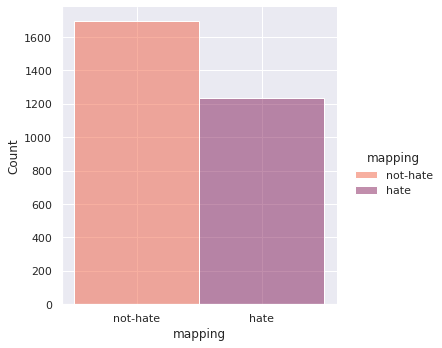

In [18]:
#Exploration of 'hate Test Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_hate_test, x='mapping', hue='mapping',palette='rocket_r')
print(mapped_hate_test.mapping.value_counts())

not-hate    5213
hate        3780
Name: mapping, dtype: int64


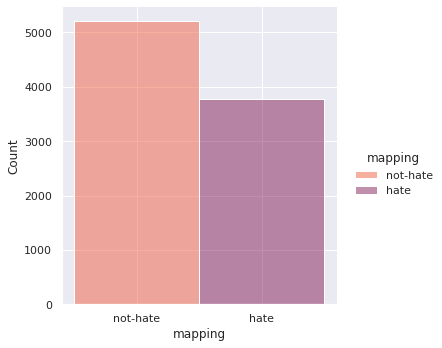

In [19]:
#Exploration of 'hate Train Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_hate_train, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_hate_train.mapping.value_counts())

not-hate    567
hate        422
Name: mapping, dtype: int64


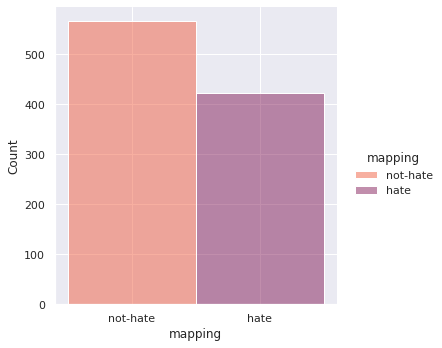

In [20]:
#Exploration of 'hate Val Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_hate_val, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_hate_val.mapping.value_counts())